# Spectral Net

### Importing the necessary Libraries

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as to
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset

## Training the Siamese Netwrok

This function is used for sorting the images of the MNIST datset

In [35]:
def secondval( value ):
    
    return value[0]

##### The Data Set for Siamese Networks

Here we define the dataset class that will be used by dataloader for training the siamese network

In [54]:
class SiamDataset(Dataset):

    def __init__(self):

        # We import the MNIST dataset that is pre formatted and kept as a csv file 
        # in which each row contains a single image flattened out to 784 pixels
        # so each row contains 784 entries
        # after the import we reshape the image in the format required by pytorch i.e. (C,H,W)

        data = list()

        img = pd.read_csv("C:\\Users\\filip\\PycharmProjects\\Siamese-network-on-MNIST-PyTorch\\Siamese\\data\\trainMNIST.csv")
        img = img.values
        img = np.reshape(img, (-1, 28, 28))
        label = pd.read_csv("C:\\Users\\filip\\PycharmProjects\\Siamese-network-on-MNIST-PyTorch\\Siamese\\data\\trainMNISTlabels.csv").values

        # Here we create a dictionary of images such that there are 10 keys 
        # each key is a class of the MNIST i.e. number b/w 0 & 9
        # each key returns a list of all the images that is labelled after it

        # we first sort the data

        for i in range(len(img)):

            data.append( [ label[i], img[i] ] )

        data.sort(key = secondval)

        self.len = len(img)

        self.img = {}

        # here we create the dictionary as said above

        for i in data:

            if i[0][0] not in self.img :
                self.img[i[0][0]] = list()
                self.img[i[0][0]].append(i[1])

            else :
                self.img[i[0][0]].append(i[1])       

        pass


    def __getitem__(self, idx):

        # this class is needed to be defined so that dataloader can be used
        # here instead of giving the real index values I have returned randomly generated images
        # so idx does not have any need but the function signature needs to be same so that the dataloader
        # can call this function

        # I create a positive pair with label of similarity 1

        clas = np.random.randint(0,10)

        length = len(self.img[clas])
        im1, im2 = np.random.randint(0,length,2)

        img1 = to.tensor(np.reshape(self.img[clas][im1],(1,28,28)), dtype=to.float32)
        img2 = to.tensor(np.reshape(self.img[clas][im2],(1,28,28)), dtype=to.float32)
        y1 = to.tensor(np.ones(1,dtype=np.float32),dtype=to.float32)

        # I create a negative pair with label of similarity 0

        len1 = len(self.img[clas])
        clas2 = ( clas + np.random.randint(0,9) ) % 9
        len2 = len(self.img[clas2])

        im3 = np.random.randint(0,len1)
        im4 = np.random.randint(0,len2)

        img3 = to.tensor(np.reshape(self.img[clas][im3],(1,28,28)), dtype=to.float32)
        img4 = to.tensor(np.reshape(self.img[clas2][im4],(1,28,28)), dtype=to.float32)
        y2 = to.tensor(np.zeros(1,dtype=np.float32),dtype=to.float32)

        return  img1, img2, y1, img3, img4, y2

    def __len__(self):

        # here I gave a smaller length than the real dataset's length so that the training can be faster

        return 10000


##### The Model Definition of Siamese Network

In [49]:
class Siamese(nn.Module):
    
    def __init__(self):
        super(Siamese,self).__init__()
        
        # A simple two layer convolution followed by three fully connected layers should do
        
        self.conv1 = nn.Conv2d(1, 8, kernel_size=3)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=3)
        
        self.pool1 = nn.MaxPool2d( kernel_size=2, stride=2)
        self.pool2 = nn.MaxPool2d( kernel_size=3)
        
        self.lin1 = nn.Linear(144, 64)
        self.lin2 = nn.Linear(64, 32)
        self.lin3 = nn.Linear(32, 10)
        
    def forward_once(self,x):
        
        # forwarding the input through the layers
          
        out = self.pool1(nn.functional.relu(self.conv1(x)))
        out = self.pool2(nn.functional.relu(self.conv2(out)))
        
        out = out.view(-1,144)
        
        out = nn.functional.relu(self.lin1(out))
        out = nn.functional.relu(self.lin2(out))
        out = self.lin3(out)
        
        return out
    
    def forward(self, x, y):    
        
        # doing the forwarding twice so as to obtain the same functions as that of twin networks
        
        out1 = self.forward_once(x)
        out2 = self.forward_once(y)
        
        return out1, out2
    
    
    def evaluate(self, x, y):
        
        # this can be used later for evalutation
        
        m = to.tensor(1.0, dtype=to.float32)
        
        if type(m) != type(x):
            x = to.tensor(x, dtype = to.float32, requires_grad = False)
            
        if type(m) != type(y):
            y = to.tensor(y, dtype = to.float32, requires_grad = False)
        
        x = x.view(-1,1,28,28)
        y = y.view(-1,1,28,28)
        
        with to.no_grad():
            
            out1, out2 = self.forward(x, y)
            
            return nn.functional.pairwise_distance(out1, out2)
        

##### Loss Function Definition for Siamese Network

Here the contrastive loss as defined in the paper is used

In [50]:
class ContrastiveLoss(nn.Module):
 
    def __init__(self, margin=2.0):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, output1, output2, label):
        
        euclidean_distance = nn.functional.pairwise_distance(output1, output2)
        
        loss_contrastive = to.mean((1-label) * to.pow(euclidean_distance, 2) +
                                      (label) * to.pow(to.clamp(self.margin - euclidean_distance, min=0.0), 2))


        return loss_contrastive

## Training

Defining necessary parameters

In [55]:
siamdset = SiamDataset()

train_dataloader = DataLoader(siamdset, shuffle=True, batch_size= 16,
                        num_workers=8)

siam = Siamese()

In [ ]:
number_epochs = 200
Criterion = ContrastiveLoss()
Optimizer = to.optim.Adam(siam.parameters(),lr = 0.001 )

In [ ]:
counter = []
loss_history = [] 
iteration_number= 0

In [ ]:
for epoch in range(0,number_epochs):
    for data in train_dataloader:
   
        img1, img2 , label1, img3, img4, label2 = data
    
        Optimizer.zero_grad()
        
        # here we obtain the positive pairs' loss as well as the negative pairs' loss
        
        output1,output2 = siam(img1,img2)
        output3,output4 = siam(img3,img4)
        
        loss_pos = Criterion(output1,output2,label1)
        loss_neg = Criterion(output3,output4,label2)
        
        # the total loss is then computed and back propagated
        
        loss_contrastive = loss_pos + loss_neg
        
        loss_contrastive.backward()
        
        Optimizer.step()
    
    # printing the training errors
    
    print("Epoch number {}\n  Current loss {}\n".format(epoch,loss_contrastive.item()))
    counter.append(epoch+100)
    loss_history.append(loss_contrastive.item())

##### Saving the model and plotting the error

In [ ]:
plt.plot(counter,loss_history)
plt.savefig("./plot/Siamese_loss")

In [ ]:
to.save(siam.state_dict(), "./Siamese model")

## Testing the model's prediction

In [51]:
%matplotlib inline

In [56]:
trial = list()

for i in range(0,5):
    trial.append(siamdset[i])

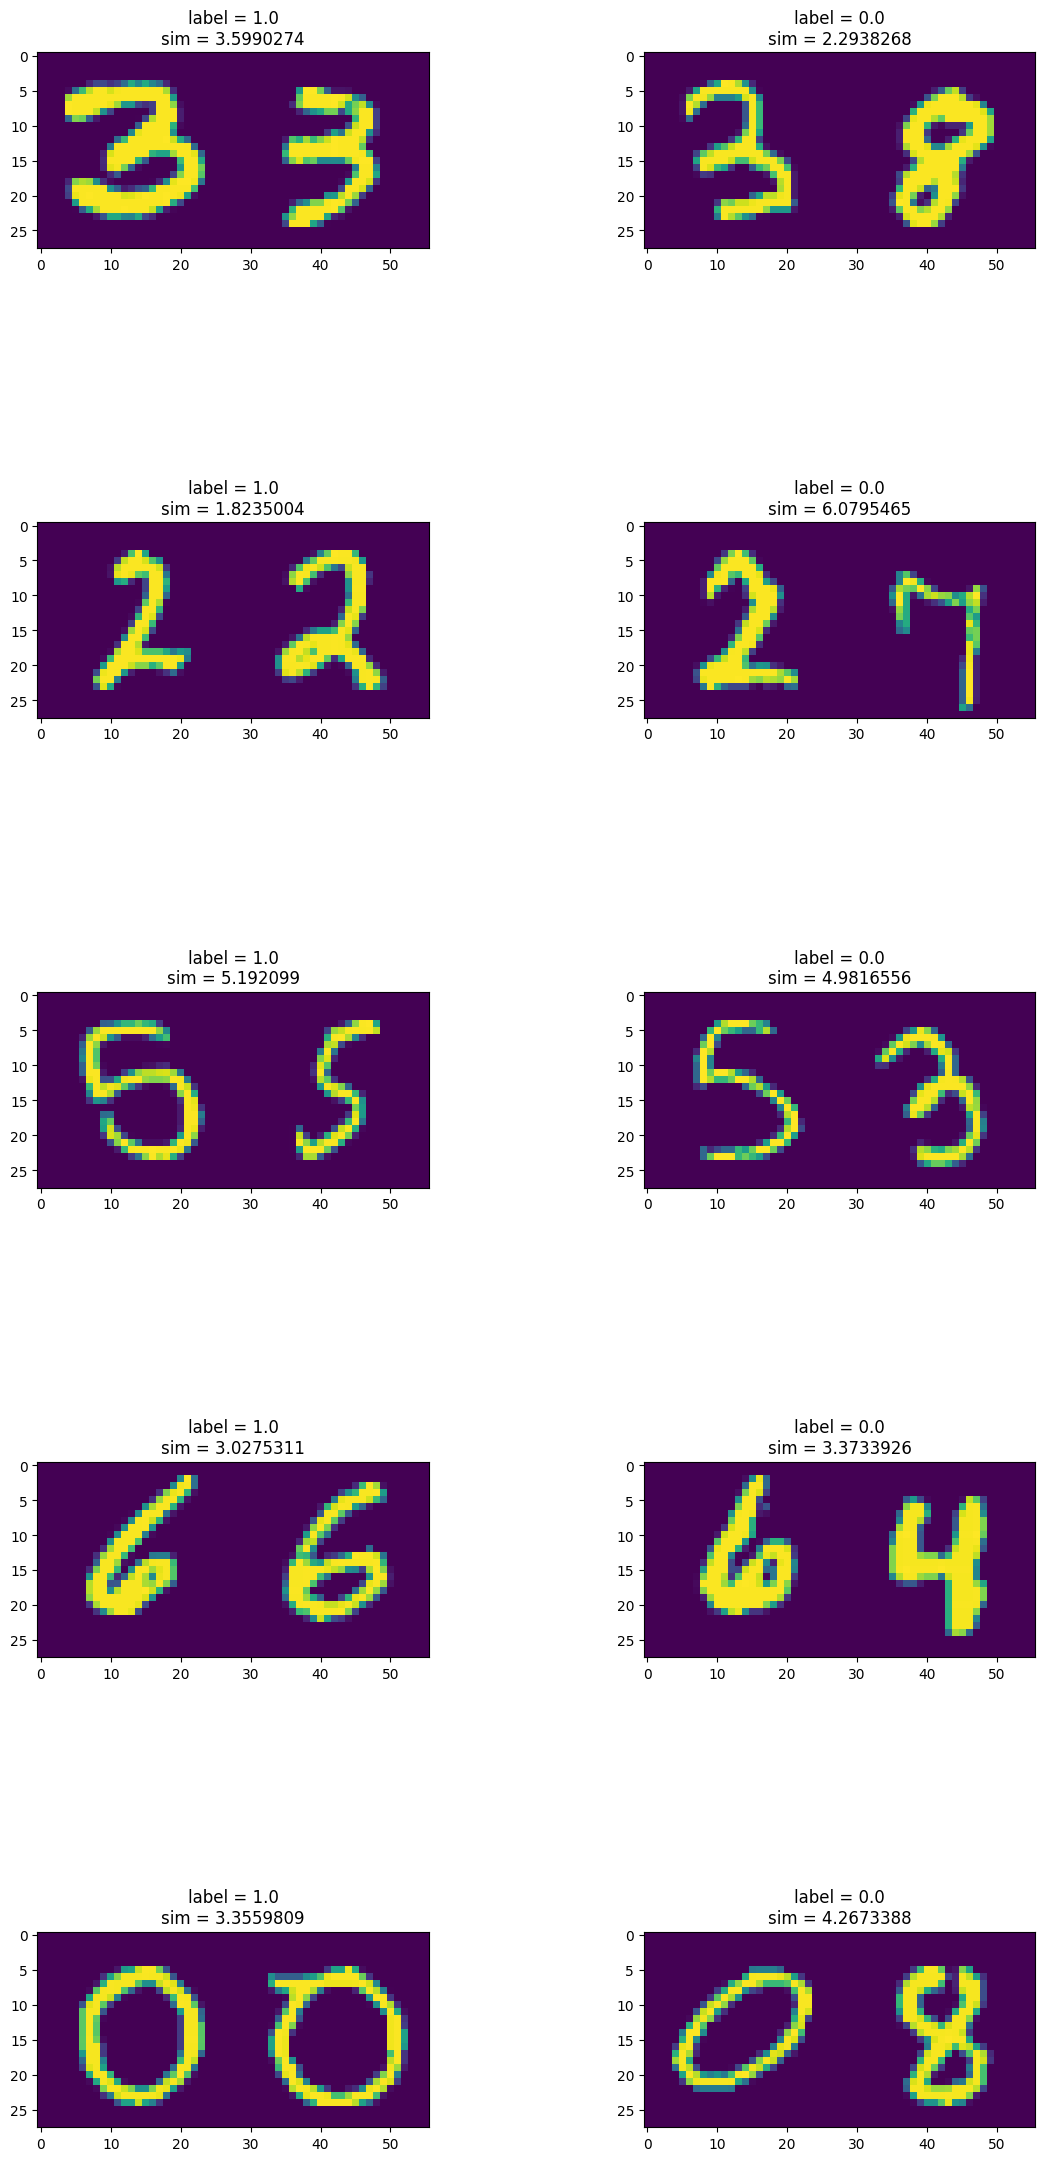

In [57]:
fig = plt.figure(1, figsize=(30,30))

i = 1 

for data in trial :

    im1, im2, lb1, im3, im4, lb2 = data

    diss1 = siam.evaluate(im1,im2)
    diss2 = siam.evaluate(im3,im4)
    
    im1 = np.concatenate((im1.numpy()[0],im2.numpy()[0]),axis=1)
    lb1 = lb1.numpy()
    
    im2 = np.concatenate((im3.numpy()[0],im4.numpy()[0]),axis=1)
    lb2 = lb2.numpy()
    
    diss1 = diss1.numpy()
    diss2 = diss2.numpy()

    ax1 = fig.add_subplot(10,4,i)
    ax1.title.set_text("label = "+str(lb1[0])+"\n"+"sim = "+str(diss1[0]))
    ax1.imshow(im1)
    
    ax2 = fig.add_subplot(10,4,i+1)
    ax2.title.set_text("label = "+str(lb2[0])+"\n"+"sim = "+str(diss2[0]))
    ax2.imshow(im2)

    i+=8


plt.show()   
fig.savefig("./plot/Siamese_test")